In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, recall_score, confusion_matrix, precision_score, f1_score
from sklearn.model_selection import GridSearchCV
import shap
import data_loader
import data_preprocessing

df = data_loader.load_bank_data('bank_data.csv')

X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled = data_preprocessing.preprocessing(df)

print("Shape of X_train_scaled:", X_train_scaled.shape)
print("Shape of X_test_scaled:", X_test_scaled.shape)

Dataset loaded successfully!
--- Data successfully preprocessed and split ---
Shape of X_train_scaled: (32950, 46)
Shape of X_test_scaled: (8238, 46)


In [2]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],
    'penalty': ['l1', 'l2']
}

grid_search = GridSearchCV(
    estimator=LogisticRegression(class_weight='balanced', random_state=42, max_iter=5000),
    param_grid=param_grid,
    scoring='recall',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)

print(f"Best Parameters Found: {grid_search.best_params_}")
print(f"Best Recall Score (from cross-validation): {grid_search.best_score_:.2%}")

best_model = grid_search.best_estimator_
y_pred_final = best_model.predict(X_test_scaled)

final_report = classification_report(y_test, y_pred_final, target_names=['No (0)', 'Yes (1)'])
print(final_report)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters Found: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Best Recall Score (from cross-validation): 62.58%
              precision    recall  f1-score   support

      No (0)       0.95      0.86      0.90      7310
     Yes (1)       0.37      0.65      0.47       928

    accuracy                           0.83      8238
   macro avg       0.66      0.75      0.69      8238
weighted avg       0.88      0.83      0.85      8238



In [3]:
best_model = grid_search.best_estimator_
print(f"Final evaluation using the best model: {best_model}")

y_pred_final = best_model.predict(X_test_scaled)

final_report = classification_report(y_test, y_pred_final, target_names=['No (0)', 'Yes (1)'])
print(final_report)

Final evaluation using the best model: LogisticRegression(C=0.1, class_weight='balanced', max_iter=5000,
                   random_state=42, solver='liblinear')
              precision    recall  f1-score   support

      No (0)       0.95      0.86      0.90      7310
     Yes (1)       0.37      0.65      0.47       928

    accuracy                           0.83      8238
   macro avg       0.66      0.75      0.69      8238
weighted avg       0.88      0.83      0.85      8238



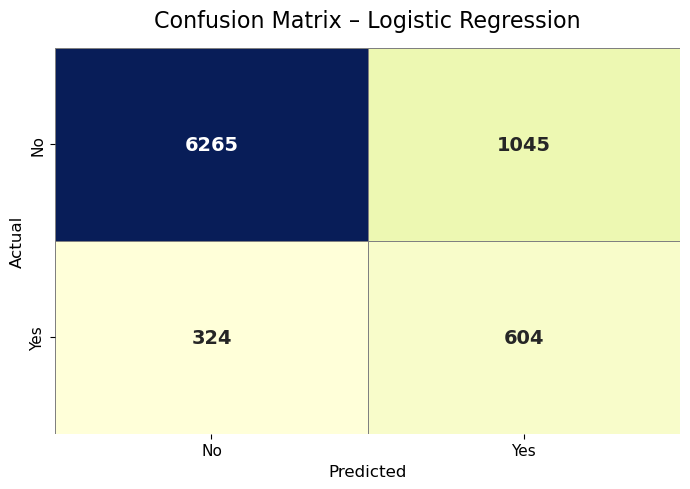

In [4]:
cm = confusion_matrix(y_test, y_pred_final)

plt.figure(figsize=(7, 5))
ax = sns.heatmap(
    cm, annot=True, fmt='d', cmap='YlGnBu', cbar=False,
    linewidths=0.5, linecolor='gray',
    xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'],
    annot_kws={"size": 14, "weight": "bold"}
)

ax.set_title(f'Confusion Matrix – Logistic Regression', fontsize=16, pad=15)
ax.set_xlabel('Predicted', fontsize=12)
ax.set_ylabel('Actual', fontsize=12)
ax.tick_params(axis='x', labelsize=11)
ax.tick_params(axis='y', labelsize=11)
plt.tight_layout()
plt.show()

In [5]:
recall = recall_score(y_test, y_pred_final, pos_label=1)
precision = precision_score(y_test, y_pred_final, pos_label=1)
f1 = f1_score(y_test, y_pred_final, pos_label=1)

metric_data = [[recall, precision, f1]]
metrics_df = pd.DataFrame(metric_data, columns=['Recall', 'Precision', 'F1-Score'])

metrics_df_melted = metrics_df.melt(var_name='Metric', value_name='Score')
print(metrics_df_melted)

      Metric     Score
0     Recall  0.650862
1  Precision  0.366283
2   F1-Score  0.468762


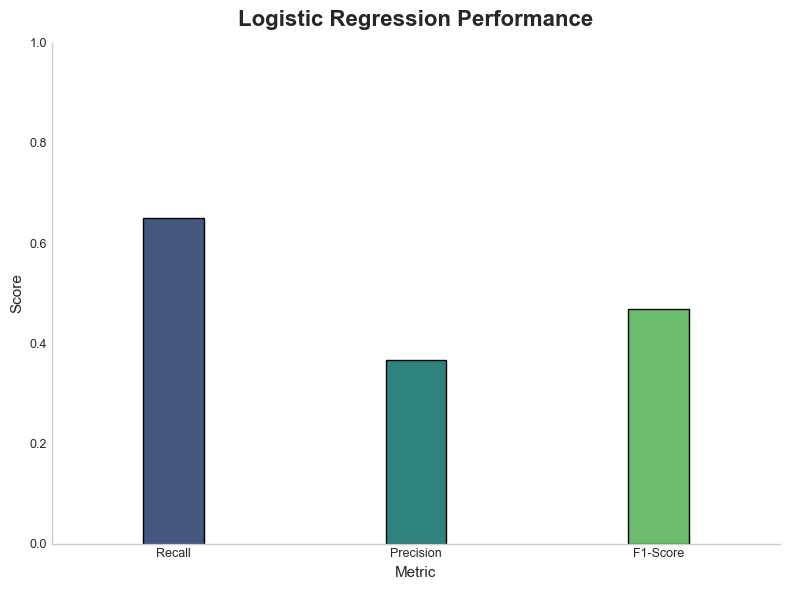

In [6]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(8, 6))
ax = sns.barplot(
    data=metrics_df_melted,
    x='Metric',
    hue = 'Metric',
    y='Score',
    palette='viridis',
    edgecolor = 'black',
    width = 0.25
)

plt.title('Logistic Regression Performance', fontsize=16, pad=12, fontweight = 'bold')
plt.xlabel('Metric', fontsize=11)
plt.ylabel('Score', fontsize=11)
plt.ylim(0, 1.05)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)

ax.grid(False)
ax.set_axisbelow(True)
plt.ylim(0, 1.0)

sns.despine()
plt.tight_layout()
plt.show()

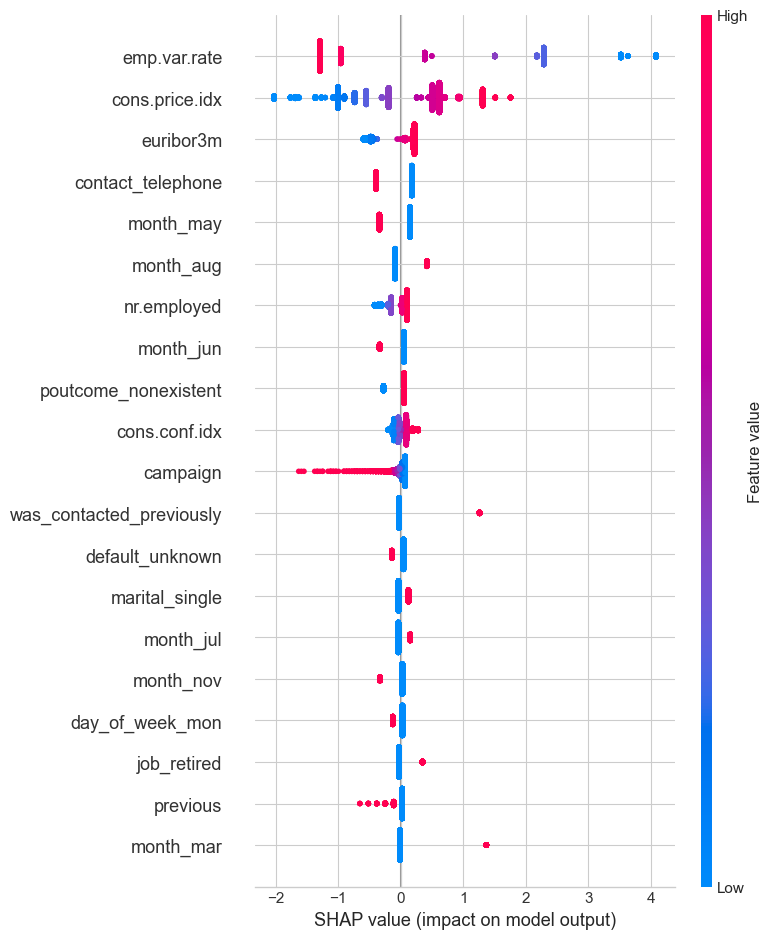

In [7]:
shap.initjs()
explainer = shap.LinearExplainer(best_model, X_train_scaled)

shap_values = explainer.shap_values(X_test_scaled)
shap.summary_plot(shap_values, X_test_scaled, feature_names=X_test.columns)

In [8]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test_scaled[0,:], feature_names=X_test.columns)